In [ ]:
#install
!pip install python_speech_features
!pip install pickle5
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=2d3591bc0916cc638f49a3e7bcebbb3e2f93e0fa8e4fc7689c35777c006de010
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=262138 sha256=277d6afb92200a5236798c68ff5cd3934155055f33fb339df408b051c7d0391c
  Stored in directory: /root/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5
Looking in in

In [ ]:
# !unzip development_set.zip

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import python_speech_features
import pickle5 as cPickle
from scipy.io.wavfile import read
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from scipy.io.wavfile import read
import seaborn as sn
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def calculate_delta(mfcc, number):
    """Calculate differential coefficients"""

    rows,cols = mfcc.shape
    deltas = np.zeros((rows,number))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( mfcc[index[0][0]]-mfcc[index[0][1]] + (2 * (mfcc[index[1][0]]-mfcc[index[1][1]])) ) / 10
    return deltas

def extract_features(signal,rate):
     
    #signal, rate, length of widow in ms, step between successive windows in seconds, the number of cepstrum to return, 
    #appendEnergy – if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    mfcc_numb = 5
    mfcc_feature = python_speech_features.mfcc(signal,rate, 0.025, 0.01,mfcc_numb,appendEnergy = True)
    
    mfcc_feature = preprocessing.scale(mfcc_feature) #standarize data
    delta = calculate_delta(mfcc_feature, mfcc_numb)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Mgr/EASAR

/content/drive/.shortcut-targets-by-id/1cCSqf0S8VsSbj8YH3OUMmtEEr6QfM5kf/EASAR


In [ ]:
#path to training data
source   = "baza_arg/"  
modelpath = "speaker_models_arg/"
train_file = "baza_arg_enroll.txt"
test_file = "baza_arg_test.txt"

In [ ]:
#path where training speakers will be saved
dest = "speaker_models_arg/"
!mkdir speaker_models_arg
file_paths = open(train_file,'r')
 
count = 1
# Extracting features for each speaker (5 files per speakers)
features = np.asarray(())
for path in file_paths:
    path = path.strip()
    print( path)
 
    # read the audio
    sr,audio = read(source + path)
 
    # extract 40 dimensional MFCC & delta MFCC features
    vector = extract_features(audio,sr)
 
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
    # when features of 5 files of speaker are concatenated, then do model training
    if count == 5:
        gmm = GMM(n_components = 2, max_iter = 200, covariance_type='diag',n_init = 3)
        gmm.fit(features)
 
        # dumping the trained gaussian model
        picklefile = path.split("-")[0]+".gmm"
        cPickle.dump(gmm,open(dest + picklefile,'wb'))
        print ('+ modeling completed for speaker:',picklefile," with data point = ",features.shape)
        features = np.asarray(())
        count = 0
    count = count + 1

mkdir: cannot create directory ‘speaker_models_arg’: File exists
speaker1-/n0010101.wav
speaker1-/n0010102.wav
speaker1-/n0010103.wav
speaker1-/n0010104.wav
speaker1-/n0010105.wav
+ modeling completed for speaker: speaker1.gmm  with data point =  (563, 10)
speaker2-/n0020101.wav
speaker2-/n0020102.wav
speaker2-/n0020103.wav
speaker2-/n0020104.wav
speaker2-/n0020105.wav
+ modeling completed for speaker: speaker2.gmm  with data point =  (824, 10)
speaker3-/n0030101.wav
speaker3-/n0030102.wav
speaker3-/n0030103.wav
speaker3-/n0030104.wav
speaker3-/n0030105.wav
+ modeling completed for speaker: speaker3.gmm  with data point =  (1500, 10)
speaker4-/n0040101.wav
speaker4-/n0040102.wav
speaker4-/n0040103.wav
speaker4-/n0040104.wav
speaker4-/n0040105.wav
+ modeling completed for speaker: speaker4.gmm  with data point =  (703, 10)
speaker6-/n0060101.wav
speaker6-/n0060102.wav
speaker6-/n0060103.wav
speaker6-/n0060104.wav
speaker6-/n0060105.wav
+ modeling completed for speaker: speaker6.gmm  wit

In [ ]:
import os
import time

file_paths = open(test_file,'r')
 
gmm_files = [os.path.join(modelpath,fname) for fname in
              os.listdir(modelpath) if fname.endswith('.gmm')]
 
#Load the Gaussian gender Models
models    = [cPickle.load(open(fname,'rb')) for fname in gmm_files]
speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname
              in gmm_files]

acc = 0
all = 0
y_test = []
y_pred = []

# Read the test directory and get the list of test audio files
for path in file_paths:   
    all+=1
    path = path.strip()
    print (path)
    sr,audio = read(source + path)
    vector   = extract_features(audio,sr)
 
    log_likelihood = np.zeros(len(models)) 
 
    for i in range(len(models)):
        gmm    = models[i]  #checking with each model one by one
        scores = np.array(gmm.score(vector))
        log_likelihood[i] = scores.sum()
 
    winner = np.argmax(log_likelihood)
    
    picklefile = path.split("-")[0]
    y_test.append(picklefile)
    y_pred.append(speakers[winner])
    print ("\tdetected as - ", speakers[winner])
    if(picklefile == speakers[winner]): acc+=1
    print('-'*20)
    time.sleep(1.0)

print("Accuracy: " , acc*100/all , "%")
print(y_test)
print(y_pred)

speaker1-/n0010106.wav
	detected as -  speaker1
--------------------
speaker1-/n0010107.wav
	detected as -  speaker1
--------------------
speaker1-/n0010108.wav
	detected as -  speaker1
--------------------
speaker1-/n0010109.wav
	detected as -  speaker1
--------------------
speaker1-/n0010110.wav
	detected as -  speaker1
--------------------
speaker2-/n0020106.wav
	detected as -  speaker2
--------------------
speaker2-/n0020107.wav
	detected as -  speaker2
--------------------
speaker2-/n0020108.wav
	detected as -  speaker2
--------------------
speaker2-/n0020109.wav
	detected as -  speaker2
--------------------
speaker2-/n0020110.wav
	detected as -  speaker2
--------------------
speaker3-/n0030106.wav
	detected as -  speaker3
--------------------
speaker3-/n0030107.wav
	detected as -  speaker3
--------------------
speaker3-/n0030108.wav
	detected as -  speaker3
--------------------
speaker3-/n0030109.wav
	detected as -  speaker3
--------------------
speaker3-/n0030110.wav
	detected a

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

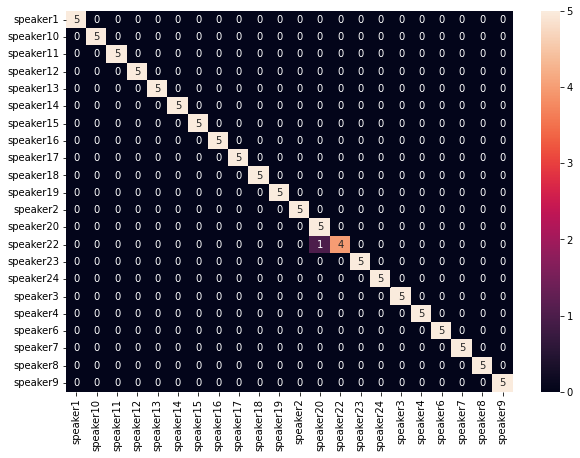

In [ ]:
df_cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
def am_I_here(path):
  path = path.strip()
  sr,audio = read(source + path)
  vector   = extract_features(audio,sr)
 
  log_likelihood = np.zeros(len(models)) 
 
  for i in range(len(models)):
    gmm    = models[i]  #checking with each model one by one
    scores = np.array(gmm.score(vector))
    log_likelihood[i] = scores.sum()
    
 
  winner = np.argmax(log_likelihood)
  print(winner)
  if(winner < 20): print('may not be in database')
  print (path +'\n' + "\tdetected as - ", speakers[winner])
  print('-'*20)

In [ ]:
am_I_here('speaker25-/n0250101.wav')

5
may not be in database
speaker25-/n0250101.wav
	detected as -  speaker7
--------------------


In [ ]:
print(log_likelihood)

[-35.44535836 -40.33490021 -37.77941545 -33.15432653 -42.21536537
 -26.29789388 -29.80544158 -38.67809859 -88.46669827 -38.160629
 -28.13671904 -43.01538219 -39.28883353 -37.3208605  -22.4967416
 -31.05866737 -34.66203045 -28.62257189 -36.82655756 -35.9080882
 -40.26888068 -10.71613066]


In [ ]:
gmm_files

['speaker_models_arg/speaker1.gmm',
 'speaker_models_arg/speaker2.gmm',
 'speaker_models_arg/speaker3.gmm',
 'speaker_models_arg/speaker4.gmm',
 'speaker_models_arg/speaker6.gmm',
 'speaker_models_arg/speaker7.gmm',
 'speaker_models_arg/speaker8.gmm',
 'speaker_models_arg/speaker10.gmm',
 'speaker_models_arg/speaker9.gmm',
 'speaker_models_arg/speaker11.gmm',
 'speaker_models_arg/speaker12.gmm',
 'speaker_models_arg/speaker14.gmm',
 'speaker_models_arg/speaker13.gmm',
 'speaker_models_arg/speaker15.gmm',
 'speaker_models_arg/speaker17.gmm',
 'speaker_models_arg/speaker16.gmm',
 'speaker_models_arg/speaker18.gmm',
 'speaker_models_arg/speaker19.gmm',
 'speaker_models_arg/speaker20.gmm',
 'speaker_models_arg/speaker22.gmm',
 'speaker_models_arg/speaker23.gmm',
 'speaker_models_arg/speaker24.gmm']